<a href="https://colab.research.google.com/github/gabrielfreire08/gabrielfreire08/blob/main/Copy_of_Base_08MIAR_Aprendizaje_por_refuerzo_Proyecto_pr%C3%A1ctico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Proyecto práctico

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, una solución óptima será alcanzada cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

   1) Implementar la red neuronal que se usará en la solución
    
   2) Implementar las distintas piezas de la solución DQN
    
   3) Justificar la respuesta en relación a los resultados obtenidos

IMPORTANTE:

- Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.

- Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).

- Tened en cuenta que las versiones de librerías recomendadas son Tensorflow==1.13.1, Keras==2.2.4 y keras-rl==0.4.2

# 0) Configuraciones y carga de entorno

## Instalar los módulos necesarios para el proyecto

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install gym==0.17.3
!pip install h5py==2.10.0
!pip install Pillow
!pip install gym[atari]
!pip install keras-rl==0.4.2
!pip install tensorflow==1.13.1
!pip install keras==2.2.4
!pip install jupyter
!pip install torch
!pip freeze

In [3]:
import tensorflow
tensorflow.__version__

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

'1.13.1'

## Importar librerías

In [14]:
from __future__ import division

from PIL import Image
import numpy as np
import gym
import random

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute, BatchNormalization, Dropout
from keras.optimizers import Adam, Nadam
import keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

## Cargar el entorno

In [5]:
%%capture
# Vamos a descargar el rom del juego
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

Cargaremos algunos utilitarios para que nos faciliten la visualización del juego en Colab.

In [6]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [7]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

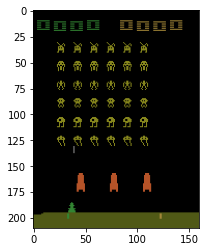

In [8]:
# Cargamos el entorno del juego
env = gym.make("SpaceInvaders-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

# Hacemos una previsualización aleatoria de frames
for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()

Cargamos el entorno del juego, en este caso SpaceInvaders

In [9]:
env = gym.make('SpaceInvaders-v0')
height, width, channels = env.observation_space.shape
actions = env.action_space.n
print(f"Acciones que puede tomar: {env.unwrapped.get_action_meanings()}")

Acciones que puede tomar: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


Veamos las acciones que tiene disponible el agente. Tenemos 6 acciones:
* No hacer nada
* Disparar
* Moverse a la izquierda
* Moverse a la derecha
* Moverse a la izquierda y disparar
* Moverse a la derecha y disparar

In [10]:
env.action_space

Discrete(6)

In [11]:
env.env.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [12]:
# Vamos a trabajar con un tamaño de frame más pequeño
# para que sea más manejable sin perder la proporción
INPUT_SHAPE=(88,80)
WINDOW_LENGTH = 4

env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

Aquí estamos probando como se comportaría el juego si lo dejamos que tome acciones aleatorias

In [15]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = random.choice([0,1,2,3,4,5])
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

Episode:1 Score:30.0
Episode:2 Score:85.0
Episode:3 Score:80.0
Episode:4 Score:285.0
Episode:5 Score:35.0


## Pre-procesado de Frames y Procesador Atari

Vamos a implementar una función de pre-procesado de frames para asegurar un nivel de análisis de patrones por parte de la red neuronal

In [16]:
color = np.array([210, 164, 74]).mean()

def preprocess_frame(obs):
    # Cortaremos la parte "jugable" (sin el marcador) y reduciremos el número de canales
    img = obs[25:201:2, ::2]

    # Convertimos a escala de grises
    img = img.mean(axis=2)

    # Mejoramos el contraste
    img[img==color] = 0

    # Normalizamos la imagen
    img = (img - 128) / 128 - 1

    # Rescalamos la imagen a 88*80*1
    img = img.reshape(88,80)

    return img 

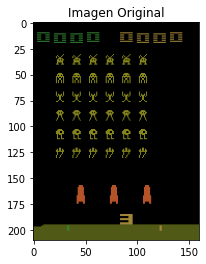

In [17]:
observation = env.reset()
# Veamos como era la imagen original
for i in range(11):
  if i > 9:
    plt.imshow(observation)
    plt.title("Imagen Original")
    plt.show()
  observation, _, _, _ = env.step(1)

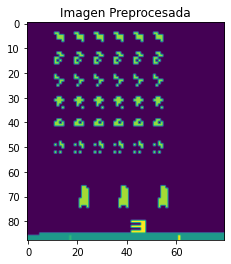

In [18]:
# Preprocessed Game Screen
obs_preprocesado = preprocess_frame(observation)
plt.imshow(obs_preprocesado)
plt.title("Imagen Preprocesada")
plt.show()

Ahora, lo último que tenemos que hacer en esta sección es implementar el preprocesado dentro de nuestro procesador Atari.

In [19]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = preprocess_frame(observation)
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

# 1) Implementar la red neuronal de la solución


In [20]:
# Definimos nuestro modelo de red neuronal. 
# Usaremos como base el modelo del artículo de Mnih et al. (2015).
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))
# Bloque convolucional
model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
# Top model
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 88, 80, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 19, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 21, 19, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 8, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 9, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 6, 64)          36928     
_________________________________________________________________
acti

# 2) Implementar las distintas piezas de la solución DQN

## Definir el tamaño de memoria

Para el proyecto vamos a usar una memoria de 1000000.

In [21]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()

## Definir la estrategia o policy

Definiremos nuestra policy como una EpsilonGreedyQPolicy, con un valor epsilon mínimo de 0.1 y uno máximo de 1. La variación será por 1000000 de steps (que coincide con el número de steps que vamos a usar en el entrenamiento)

In [22]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

## Configurar agente DQN

Configuramos nuestro modelo, número de acciones, política y memoria previamente definidos. Definiremos un calentamiento de 50000 steps en el cual el modelo no actualizará nada, nuestro gamma o discount rate tendrá un valor de 0.99 para darle mucha importancia a las recompensas de estados previos. Nuestro modelo se actualizará cada 10000 steps y el intervalo de entrenamiento lo definiremos en 6 acciones.

In [23]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy,
               memory=memory, processor=processor,
               nb_steps_warmup=50000, gamma=.99,
               target_model_update=10000,
               train_interval=30)

# Usaremos un optimizador Nadam con learning rate de 0.003.
#dqn.compile(Nadam(lr=.003), metrics=['mse'])
dqn.compile(Adam(lr=.00025), metrics=['mae'])

# Entrenamiento del agente

In [ ]:
# Configuramos los callbacks que vamos a necesitar
weights_filename = '/content/drive/MyDrive/ProyectoRL/dqn_{}_weights.h5'.format(env_name)
checkpoint_weights_filename = 'dqn_' + env_name + '_weights_{step}.h5'
log_filename = 'dqn_{}_log.json'.format(env_name)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]

# Iniciamos el entrenamiento del agente
dqn.fit(env, callbacks=callbacks, nb_steps=1750000, log_interval=10000, visualize=False)

# Guardamos los pesos
dqn.save_weights(weights_filename, overwrite=True)

Training for 1750000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 39s 4ms/step - reward: 0.0128
14 episodes - episode_reward: 9.071 [4.000, 16.000] - ale.lives: 2.176

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 39s 4ms/step - reward: 0.0121
12 episodes - episode_reward: 9.833 [4.000, 12.000] - ale.lives: 2.109

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 39s 4ms/step - reward: 0.0130
15 episodes - episode_reward: 8.133 [4.000, 14.000] - ale.lives: 1.989

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 39s 4ms/step - reward: 0.0125
14 episodes - episode_reward: 9.214 [3.000, 19.000] - ale.lives: 2.184

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 39s 4ms/step - reward: 0.0119
17 episodes - episode_reward: 7.294 [2.000, 13.000] - ale.lives: 2.193

Interval 6 (50000 steps performed)
    1/10000 [.....

In [ ]:
# Testing part to calculate the mean reward
weights_filename = 'dqn_{}_weights_1500000.h5'.format(env_name)
dqn.load_weights(weights_filename)
dqn.test(env, nb_episodes=10, visualize=False)

In [ ]:
# Testing part to calculate the mean reward
weights_filename = 'dqn_{}_weights_1750000.h5'.format(env_name)
dqn.load_weights(weights_filename)
dqn.test(env, nb_episodes=50, visualize=False)